In [14]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import tensorflow as tf



In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [3]:
# load dataset
dataset = read_csv('../data/cleaned/train.csv', header=0, index_col=0)
dataset = dataset.reset_index()


In [4]:
dataset.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'WeekOfYear',
       'Year', 'Month', 'is_month_end', 'is_month_start', 'is_quarter_end',
       'is_quarter_start', 'is_year_end', 'is_year_start',
       'DistanceToNextHoliday', 'DistanceFromPrevHoliday'],
      dtype='object')

In [5]:
columns = [i for i in range(dataset.shape[1])]
columns.remove(3)

In [7]:
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict


In [8]:
reframed.drop(
    reframed.columns[columns], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = (2*365+365//2)*1115
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



   var4(t-1)  var1(t)   var2(t)   var3(t)   var4(t)  var5(t)  var6(t)  \
1   0.126664      0.0  0.500000  0.998937  0.120815      1.0      1.0   
2   0.120815      0.0  0.333333  0.997875  0.115087      1.0      1.0   
3   0.115087      0.0  0.166667  0.996812  0.120599      1.0      1.0   
4   0.120599      0.0  0.000000  0.995749  0.146856      1.0      1.0   
5   0.146856      0.0  1.000000  0.994686  0.000000      0.0      0.0   

   var7(t)  var8(t)   var9(t)  ...  var19(t)  var20(t)  var21(t)  var22(t)  \
1      0.0      1.0  0.666667  ...       1.0  0.545455       0.0       0.0   
2      0.0      1.0  0.666667  ...       1.0  0.545455       0.0       0.0   
3      0.0      1.0  0.666667  ...       1.0  0.545455       0.0       0.0   
4      0.0      1.0  0.666667  ...       1.0  0.545455       0.0       0.0   
5      0.0      0.0  0.666667  ...       1.0  0.545455       0.0       0.0   

   var23(t)  var24(t)  var25(t)  var26(t)  var27(t)  var28(t)  
1       0.0       0.0       

In [9]:
tf.compat.v1.disable_eager_execution()

In [10]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                15800     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 15,851
Trainable params: 15,851
Non-trainable params: 0
_________________________________________________________________


2022-09-10 12:17:36.203063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-10 12:17:36.203226: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Train on 1016880 samples, validate on 328 samples
Epoch 1/10
1016880/1016880 - 112s - loss: 0.0059 - val_loss: 0.0034 - 112s/epoch - 111us/sample
Epoch 2/10
1016880/1016880 - 115s - loss: 0.0058 - val_loss: 0.0038 - 115s/epoch - 113us/sample
Epoch 3/10
1016880/1016880 - 114s - loss: 0.0057 - val_loss: 0.0032 - 114s/epoch - 112us/sample
Epoch 4/10
1016880/1016880 - 114s - loss: 0.0055 - val_loss: 0.0047 - 114s/epoch - 112us/sample
Epoch 5/10
1016880/1016880 - 114s - loss: 0.0053 - val_loss: 0.0043 - 114s/epoch - 112us/sample
Epoch 6/10
1016880/1016880 - 115s - loss: 0.0052 - val_loss: 0.0036 - 115s/epoch - 113us/sample
Epoch 7/10
1016880/1016880 - 113s - loss: 0.0051 - val_loss: 0.0048 - 113s/epoch - 111us/sample
Epoch 8/10
1016880/1016880 - 116s - loss: 0.0049 - val_loss: 0.0032 - 116s/epoch - 114us/sample
Epoch 9/10
1016880/1016880 - 111s - loss: 0.0047 - val_loss: 0.0035 - 111s/epoch - 109us/sample
Epoch 10/10
1016880/1016880 - 115s - loss: 0.0046 - val_loss: 0.0025 - 115s/epoch - 11

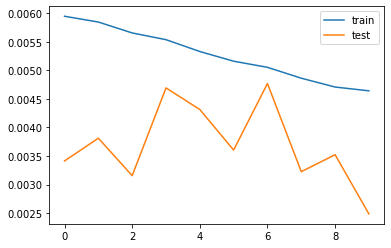

/Users/user/miniforge3/envs/10A/lib/python3.10/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2022-09-10 13:07:42.376587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test RMSE: 5.193


In [13]:

# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=72,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]


In [15]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

r2 = r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)


Test RMSE: 5.193
Test R2: 0.993
